# Read Data and Split

In [5]:
# Load all helper function
%run -i 'source.py'

dataset = pd.read_feather("../processing/train_with_feature.feather")
X = dataset[numc_features + ohe_features + te_features]
y = dataset['is_attributed']

** Dataset too big. Use only 500k rows. **

In [6]:
X, _,y,_ = train_test_split(X,y,random_state=4995,train_size=.0081,stratify=y)
print(len(X))

505123


**ALWAYS DO SAME TRAIN TEST SPLIT**

In [7]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, random_state=4995, test_size=0.2, stratify=y)

In [8]:
print(f'Proportion of data in development set: {len(X_dev)/len(X):0.2f}')
print('Confirm we have a stratified split. 0 represents negative (no download); 1 represents positive (yes download)')
import numpy as np
print(f'Proportion of positives in entire data set: {np.mean(y):0.5f}')
print(f'Proportion of positives in development set: {np.mean(y_dev):0.5f}')
print(f'Proportion of positives in test set: {np.mean(y_test):0.5f}')

Proportion of data in development set: 0.80
Confirm we have a stratified split. 0 represents negative (no download); 1 represents positive (yes download)
Proportion of positives in entire data set: 0.00243
Proportion of positives in development set: 0.00243
Proportion of positives in test set: 0.00243


# Preprocessing

## SMOTE

In [9]:
smote = SMOTE(random_state = 0)
X_dev_SMOTE, y_dev_SMOTE = smote.fit_resample(X_dev, y_dev) # It is okay to do smote first since for now we are not doing any hyperparameter tuning.
print(f'After SMOTE our development label balance is:\n{y_dev_SMOTE.value_counts()}')

After SMOTE our development label balance is:
0    403117
1    403117
Name: is_attributed, dtype: int64


In [21]:
#Prepare a smote set where the ratio of 1:0 is now 10: 100 instead of the simple 50:50
smote_10 = SMOTE(random_state = 0, sampling_strategy = {1: round(y_dev.value_counts()[0]/10) })
X_dev10, y_dev10 = smote_10.fit_resample(X_dev, y_dev)
print(f'After 1:10 SMOTE our development label balance is:\n{y_dev10.value_counts()}')

After 1:10 SMOTE our development label balance is:
0    403117
1     40312
Name: is_attributed, dtype: int64


# Build Models

## Baseline Model (no tuning or subsampling)

In [24]:
#Baseline training w/no tuning or subsampling
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_dev,y_dev)

LGBMClassifier()

In [25]:
lgb_model_predictions = lgb_model.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test,lgb_model_predictions)}')
print(f'Recall: {recall_score(y_test,lgb_model_predictions)}')
print(f'Precision: {precision_score(y_test,lgb_model_predictions)}')
print(f'F-1 Score: {f1_score(y_test,lgb_model_predictions)}')

precision, recall = precision_score(y_test,lgb_model_predictions), recall_score(y_test,lgb_model_predictions)

Accuracy: 0.9984261321455086
Recall: 0.7877551020408163
Precision: 0.6433333333333333
F-1 Score: 0.708256880733945


In [26]:
lgb_prob_pred = lgb_model.predict_proba(X_test)[:, 1]

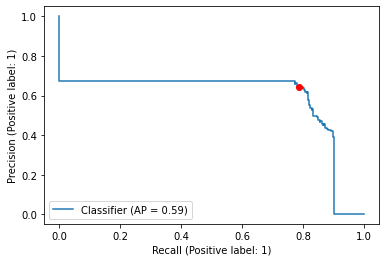

In [27]:
PrecisionRecallDisplay.from_predictions(y_test, lgb_prob_pred)
plt.plot(recall,precision,'ro');

In [28]:
def print_metrics(lgb_model, X_test, y_test):
    lgb_model_preds = lgb_model.predict(X_test)

    print(f'Accuracy: {accuracy_score(y_test,lgb_model_preds)}')
    print(f'Recall: {recall_score(y_test,lgb_model_preds)}')
    print(f'Precision: {precision_score(y_test,lgb_model_preds)}')
    print(f'F-1 Score: {f1_score(y_test,lgb_model_preds)}')

    precision, recall = precision_score(y_test,lgb_model_preds), recall_score(y_test,lgb_model_preds)
    return precision, recall

## With SMOTE Sampling

Accuracy: 0.9987923781242267
Recall: 0.8816326530612245
Precision: 0.6990291262135923
F-1 Score: 0.7797833935018051


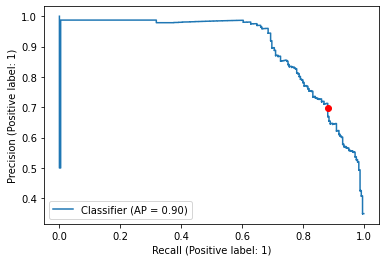

In [29]:
lgb_model_smote = lgb.LGBMClassifier()
lgb_model_smote.fit(X_dev_SMOTE,y_dev_SMOTE)

precision_smote, recall_smote = print_metrics(lgb_model_smote, X_test, y_test)

lgb_prob_smote = lgb_model_smote.predict_proba(X_test)[:, 1]

PrecisionRecallDisplay.from_predictions(y_test, lgb_prob_smote)
plt.plot(recall_smote,precision_smote,'ro');

In [34]:
lgb_model_smote.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

### Hyperparameter Tuning on SMOTE

#### Tuning on 50:50 smote

In [30]:
params = {'num_leaves': [31, 63, 127],
          'max_depth': [-1, 10, 20, 40],
          'n_estimators': [100,200,300]}

grid_lgbm = GridSearchCV(lgb.LGBMClassifier(random_state = 0), params, cv = 5, error_score = 'raise')
grid_lgbm.fit(X_dev_SMOTE,y_dev_SMOTE)

GridSearchCV(cv=5, error_score='raise',
             estimator=LGBMClassifier(random_state=0),
             param_grid={'max_depth': [-1, 10, 20, 40],
                         'n_estimators': [100, 200, 300],
                         'num_leaves': [31, 63, 127]})

In [31]:
prec_hyp, recall_hyp = print_metrics(grid_lgbm, X_test, y_test)
print(f"Best Parameters: {grid_lgbm.best_params_}")

Accuracy: 0.9990299430833952
Recall: 0.7959183673469388
Precision: 0.8024691358024691
F-1 Score: 0.7991803278688524
Best Parameters: {'max_depth': 10, 'n_estimators': 300, 'num_leaves': 63}


In [33]:
#Save model
filename = '../processing/LightGBM.sav'
pickle.dump(grid_lgbm, open(filename, 'wb'))

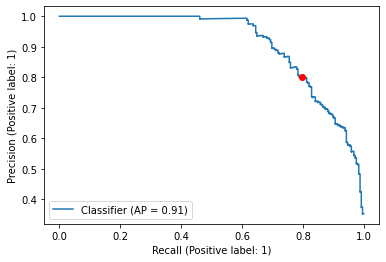

In [34]:
grid_lgb_pred=grid_lgbm.best_estimator_.predict_proba(X_test)[:, 1]

PrecisionRecallDisplay.from_predictions(y_test, grid_lgb_pred)
plt.plot(recall_hyp,prec_hyp,'ro');

In [35]:
grid_lgbm.best_estimator_.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 300,
 'n_jobs': -1,
 'num_leaves': 63,
 'objective': None,
 'random_state': 0,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

#### Hyperparam tuning on 10:100 SMOTE

In [36]:
params = {'num_leaves': [31, 63, 127],
          'max_depth': [10, 20, 40],
          'n_estimators': [100,200,300]}
grid_lgbm = GridSearchCV(lgb.LGBMClassifier(random_state = 0), params, cv = 5, error_score = 'raise')
grid_lgbm.fit(X_dev10,y_dev10)

GridSearchCV(cv=5, error_score='raise',
             estimator=LGBMClassifier(random_state=0),
             param_grid={'max_depth': [10, 20, 40],
                         'n_estimators': [100, 200, 300],
                         'num_leaves': [31, 63, 127]})

In [37]:
prec_hyp_smote, recall_hyp_smote = print_metrics(grid_lgbm, X_test, y_test)
print(f"Best Parameters: {grid_lgbm.best_params_}")

Accuracy: 0.9990200445434299
Recall: 0.7795918367346939
Precision: 0.809322033898305
F-1 Score: 0.7941787941787943
Best Parameters: {'max_depth': 20, 'n_estimators': 200, 'num_leaves': 127}


In [38]:
#Save 2nd model
filename = '../processing/LightGBM_SMOTE_10p.sav'
pickle.dump(grid_lgbm, open(filename, 'wb'))

In [45]:
#Check model can be reloaded
loaded_lgbm = pickle.load(open('../processing/LightGBM.sav', 'rb'))
loaded_lgbm.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 300,
 'n_jobs': -1,
 'num_leaves': 63,
 'objective': None,
 'random_state': 0,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [43]:
#Check reloaded model is the same
preds = loaded_lgbm.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test,preds)}')
print(f'Recall: {recall_score(y_test,preds)}')
print(f'Precision: {precision_score(y_test,preds)}')
print(f'F-1 Score: {f1_score(y_test,preds)}')

Accuracy: 0.9990299430833952
Recall: 0.7959183673469388
Precision: 0.8024691358024691
F-1 Score: 0.7991803278688524
